In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('../Datasets/titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def preprocess(data):
    def fix_age(age):
        if np.isnan(age):
            return -1
        else:
            return age
    
    data.loc[:, 'Gender'] = data.Gender.apply(lambda s: int(s == 'female'))
    data.loc[:, 'Age'] = data.Age.apply(fix_age)
    
    embarked = pd.get_dummies(data.Embarked, prefix='Emb')[['Emb_C','Emb_Q','Emb_S']]
    cols = ['Pclass','Gender','Age','SibSp','Parch','Fare']
    
    return pd.concat([data[cols], embarked], axis=1).values

In [4]:
train, val = train_test_split(data, test_size=0.2, random_state=11)

x_train = preprocess(train)
y_train = train['Survived'].values

x_val = preprocess(val)
y_val = val['Survived'].values

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(712, 9)
(712,)
(179, 9)
(179,)


/Users/ashish.jha/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [6]:
dt_params = {
    'criterion': 'entropy',
    'random_state': 11
}
dt = DecisionTreeClassifier(**dt_params)

bc_params = {
    'base_estimator': dt,
    'n_estimators': 50,
    'max_samples': 0.5,
    'random_state': 11,
    'n_jobs': -1
}
bc = BaggingClassifier(**bc_params)

In [7]:
bc.fit(x_train, y_train)
bc_preds_train = bc.predict(x_train)
bc_preds_val = bc.predict(x_val)

print('Bagging Classifier:\n> Accuracy on training data = {:.4f}\n> Accuracy on validation data = {:.4f}'.format(
    accuracy_score(y_true=y_train, y_pred=bc_preds_train),
    accuracy_score(y_true=y_val, y_pred=bc_preds_val)
))

Bagging Classifier:
> Accuracy on training data = 0.9270
> Accuracy on validation data = 0.8659


In [8]:
dt.fit(x_train, y_train)
dt_preds_train = dt.predict(x_train)
dt_preds_val = dt.predict(x_val)

print('Decision Tree:\n> Accuracy on training data = {:.4f}\n> Accuracy on validation data = {:.4f}'.format(
    accuracy_score(y_true=y_train, y_pred=dt_preds_train),
    accuracy_score(y_true=y_val, y_pred=dt_preds_val)
))


Decision Tree:
> Accuracy on training data = 0.9831
> Accuracy on validation data = 0.7709


In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
rf_params = {
    'n_estimators': 100,
    'criterion': 'entropy',
    'max_features': 0.5,
    'min_samples_leaf': 10,
    'random_state': 11,
    'n_jobs': -1
}
rf = RandomForestClassifier(**rf_params)

In [11]:
rf.fit(x_train, y_train)
rf_preds_train = rf.predict(x_train)
rf_preds_val = rf.predict(x_val)

print('Random Forest:\n> Accuracy on training data = {:.4f}\n> Accuracy on validation data = {:.4f}'.format(
    accuracy_score(y_true=y_train, y_pred=rf_preds_train),
    accuracy_score(y_true=y_val, y_pred=rf_preds_val)
))

Random Forest:
> Accuracy on training data = 0.8385
> Accuracy on validation data = 0.8771


In [12]:
from sklearn.ensemble import AdaBoostClassifier

In [13]:
dt_params = {
    'max_depth': 1,
    'random_state': 11
}
dt = DecisionTreeClassifier(**dt_params)

ab_params = {
    'n_estimators': 100,
    'base_estimator': dt,
    'random_state': 11
}
ab = AdaBoostClassifier(**ab_params)

In [14]:
ab.fit(x_train, y_train)
ab_preds_train = ab.predict(x_train)
ab_preds_val = ab.predict(x_val)

print('Adaptive Boosting:\n> Accuracy on training data = {:.4f}\n> Accuracy on validation data = {:.4f}'.format(
    accuracy_score(y_true=y_train, y_pred=ab_preds_train),
    accuracy_score(y_true=y_val, y_pred=ab_preds_val)
))

Adaptive Boosting:
> Accuracy on training data = 0.8272
> Accuracy on validation data = 0.8547


In [15]:
ab_params = {
    'base_estimator': dt,
    'random_state': 11
}

n_estimator_values = list(range(10, 210, 10))
train_accuracies, val_accuracies = [], []

for n_estimators in n_estimator_values:
    ab = AdaBoostClassifier(n_estimators=n_estimators, **ab_params)
    ab.fit(x_train, y_train)
    ab_preds_train = ab.predict(x_train)
    ab_preds_val = ab.predict(x_val)
    
    train_accuracies.append(accuracy_score(y_true=y_train, y_pred=ab_preds_train))
    val_accuracies.append(accuracy_score(y_true=y_val, y_pred=ab_preds_val))

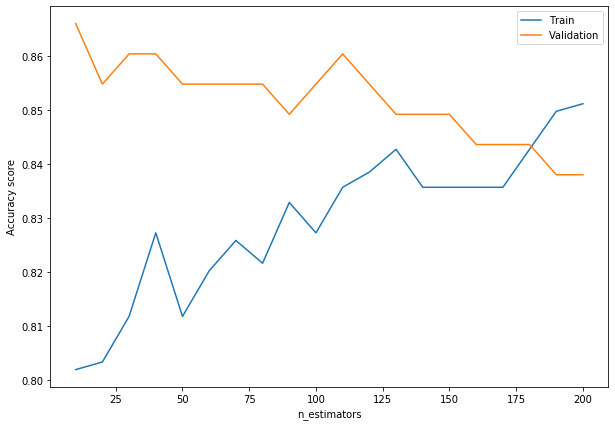

In [16]:
plt.figure(figsize=(10,7))
plt.plot(n_estimator_values, train_accuracies, label='Train')
plt.plot(n_estimator_values, val_accuracies, label='Validation')

plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')

plt.legend()
plt.show()